## Is it a bird?

CAN RUN ON MY LOUSY LAPTOP (16GB RAM, NO Nvidia GPU) 

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os

!pip install -U fastai duckduckgo_search

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: duckduckgo_search
    Found existing installation: duckduckgo-search 2.8.5
    Uninstalling duckduckgo-search-2.8.5:
      Successfully uninstalled duckduckgo-search-2.8.5

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

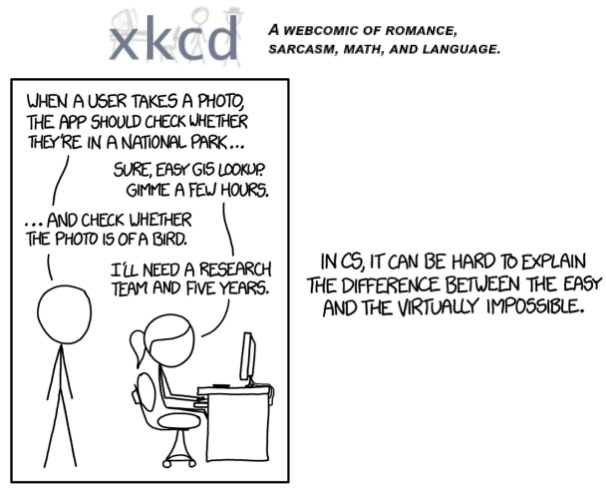

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # `itemgot` here will return a list of only the objects under a given key
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://2.bp.blogspot.com/-g9STQqFQ9Ik/UScse2IifqI/AAAAAAAAA08/mh1immEtVZo/s1600/bluebird.jpg'

...and then download a URL and take a look at it:

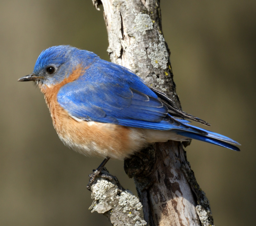

In [5]:
from fastdownload import download_url
dest = 'example_bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


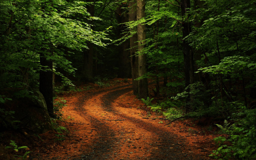

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'example_forest.jpg', show_progress=False)
Image.open('example_forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
from fastai.imports import *
from fastai.vision.utils import download_images

searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path)) # TODO test removal of images in subfolders
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

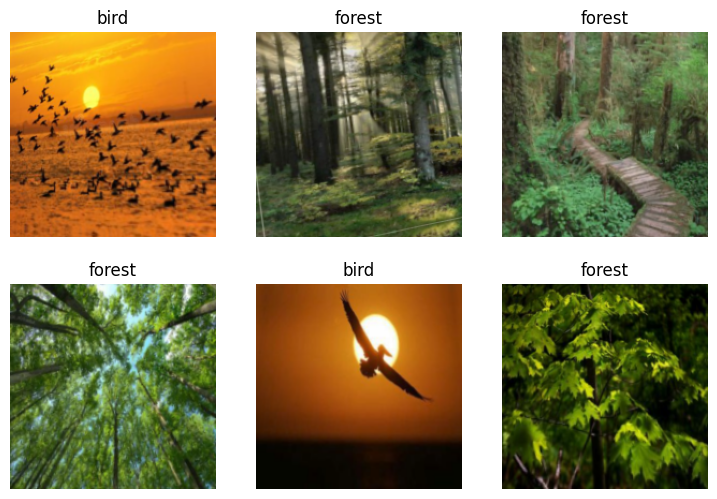

In [12]:
dls = DataBlock(
    # 1st parameter: what kind of input/output do we have ?
    blocks=(ImageBlock, CategoryBlock),
    # 2nd parameter: what things are we going to train from ?
    get_items=get_image_files,
    # 3rd parameter: what data do we set aside to test the accuracy of our model ?
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # 4th parameter: how do we know the correct label for each image ?
    get_y=parent_label,
    # 5th parameter: how do we make all the input images the same size ?
    item_tfms=[Resize(192, method='squish')],
    # 6th parameter: how do we distort the images to make our model more robust ?
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

# this says "show me a batch of data that you are passing to the model"
# it will automatically show you useful data
dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

`blocks` defines the type of the input and labels; `ImageBlock` creates images from filenames and `CategoryBlock` specifies that we will use single labels as categories, a category is one of a number of possibilities. `CategoryBlock` represents the output here.
Data blocks are very versatile and flexible, but you also have more specialized classes at your disposal (for instance for segmentation).

    get_items=get_image_files,

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest"). To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set, e.g. not to be used for the training at all. Setting a fixed seed here that the random generation is deterministic (i.e. we'll always get the same split). This is easier for debugging and for making sure that not every label will be known by the model after a few training rounds.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

`batch_tfms=aug_transforms()` applies a list of data augmentation transforms to the images in a batch. 

A `Transform` contains code that is applied automatically during training.
Data augmentation transforms are operations that modify the images slightly (flipping, rotating, zooming, etc.). These transforms help improve the performance of the model by making it more robust to variations in input data.

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

`dls` contains iterators that PyToch can run through to train a model. `dls` is short for `DataLoaders`.

Calling `dataloaders(path, bs=32)` converts the data block into a data loader, with a given path and batch size. Data Loaders are the things that PyTorch iterates through to grab a bunch of data at a time. A data loader feeds the training algorithm with a lot of data at a time.

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18` (https://www.kaggle.com/datasets/pytorch/resnet18). `resnet18` is a pretrained version of a convolutional neural network that has been trained on more than a million of images. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
# 1st paramter: the data in the form of a DataLoaders object
# 2nd parameter: the model we want to train (we could have used any of the `timm` models here)
learn = vision_learner(dls, resnet18, metrics=error_rate)
# this has been fine-tuned with the purpose of recognizing birds pictures from forest pictures
learn.fine_tune(3)

/home/yactouat/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yactouat/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yactouat/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.7MB/s]

A _Learner_ is something which combines a model (the actual neural network function to train) and the data that has been used to train it with.
 
Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

Fine-tuning here consists of teaching the model to recognize your input images and the ones it has been initially trained with.

Here, `learn.fine_tune(3)` means we'll train for 3 _epochs_, e.g. 3 complete passes through all our data. At each new epoch, the model gets to improve using the entire dataset.

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [15]:
is_bird_as_a_string,is_bird_as_an_integer,probs = learn.predict(PILImage.create('example_forest.jpg')) # Here we created a Python Image Library object from our example bird image.
print(f"This is a: {is_bird_as_a_string}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.